## Random Forest

Decision trees are not really used on their own in machine learning. You really only see them in situations where understanding the model's decisions is extremely important.

Instead, a much more common use of decision trees is to use them in **ensembles**. An ensemble is basically a group of models used together to make a prediction. Often, ensembling multiple models leads to a stronger predictive model, but you lose some ability to interpret the model.

Random forests train a bunch of decision trees that are all different and then combine them via **voting.** Basically, you take the most common predicted class as the prediction (hard voting) and you can get probabilities by taking the fraction (soft voting). It is fairly easy to see how multiple models might be more effective than a single model if they all look at the data in a different way. For example, if you wanted to know whether a movie is good, you probably don't just ask one person. Instead you ask many different people with different preferences.

Note: random forests also work for regression problems, you just use the average predicted value instead of voting.

Random forests are one of the most popular models in machine learning. Here is a nice paper that compares many models and shows how well random forests fair:

http://lowrank.net/nikos/pubs/empirical.pdf

### Some intuition 

P. 183 of Hands on Machine Learning has one of the nicest explanations of why combining weak learners can led to a strong learner. Let's take a look!

One of the main take aways is that you want your models to be as independent as possible. Thus, when ensembling you want to do as much as you can to have diverse models. There are a few ways you can try and get this diversity:

1. Train many different models on the same data where each model is different. For example, one SVM, one logistic regression, and one k-nearest kneighbors. You can see how to do this in sklearn on p. 184 of Hands on Machine Learning. We won't dive too deep into this method, but it is pretty simple and can be pretty effective. 

2. ### Bagging (Bootstrapping)

Bagging uses the same model for each predictor, but each model gets a different view of the same data. How do we create different views? Simple - each model randomly samples from the training data **with replacement**. Each sample is the same size as the original training data, but since you sample with replacement each model only sees about 63% of the data - the rest are duplicates. Note: resampling without replacement is called pasting - but this is rarely used.

Benefits:

* Scales very well since training and prediction can be run in parallel
* Ensemble has lower variance than the single model

P. 186 of Hands on Machine Learning has an sklearn example of Bagging.

Since each model only sees about 63% of the data, that means there is about 37% of the data per model that isn't used for training. These are called **out-of-bag samples**. We can use these samples for evaluation without actually needing a cross-validation set. This can be useful with very large data where training multiple cross-validated models can be costly.

3. ### Random patches and subspaces

This is a simple idea - you randomly sample the features that each model can see. Random patches is sampling both features and samples. Sampling only features is called random subspaces. Sampling features can be especially effective when you have many features (high dimensions). Again, this typically lowers variance 


## Random Forest

Now that we understand all these methods, it is pretty easy to understand random forest. Random forests use decision trees with bagging and random subspaces = random patches. SKlearn's implementation uses a random subset of features equal to sqrt(number of features) and a sample size of the same size as default values. That's it! Pretty amazing how a few fairly simple ideas on top of a pretty weak model - decision trees - can be so powerful. 

And again the intuition is that we are doing as much as we can to de-correlate our trees, which reduces the variance of our estimate. If all of our trees were very correlated then we do not gain much. 

### Feature Importances

Remember that one of the benefits of decision trees was that they are easy to understand. When ensembling them, though, we lose some of this simplicity. Fortunately, it is still pretty easy to get an understanding of which features are important.

A common way to do this is to measure the impact of each feature on reducing the impurity of the tree on average. For example, if in one of our trees is splitting on gender and this decreases the impurity by 10 across 100 samples and another tree in our random forest also split on gender reducing impurity by 5 across 10 nodes, we would calculate the weighted average (weighted by the sizes) to get the importance of this feature. Thus, higher is better.

### SKLearn Example

In [46]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.20, random_state=42)

In [4]:
Counter(y_train)

Counter({0: 169, 1: 286})

In [29]:
n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 3 balanced
1000 3 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 3 balanced
2500 3 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None
5000 3 balanced
5000 3 None
5000 5 balanced
5000 5 None
5000 10 balanced
5000 10 None


In [31]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.9740034662045061
Best params: (2500, 10, 'balanced')


In [32]:
clf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
clf.fit(X_train, y_train)
test_predictions = clf.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.93      0.95        43
          1       0.96      0.99      0.97        71

avg / total       0.97      0.96      0.96       114



In [39]:
feature_imp = sorted(list(zip(data.feature_names, clf.feature_importances_)), key=lambda x: x[1], reverse=True)

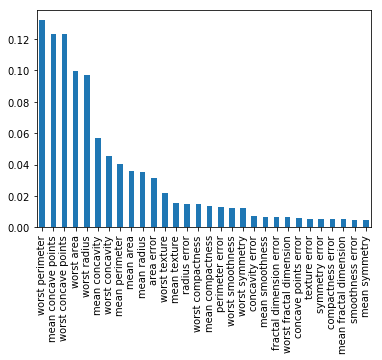

In [47]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')